<a href="https://colab.research.google.com/github/EnricMaestre/pricing_op/blob/main/proyecto_ML_Enric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Proyecto: Optimización de Precios para Maximizar Ventas usando XGBoost**

Objetivo Principal:
Optimizar los precios de los productos en una plataforma de parafarmacia para maximizar el beneficio total, asegurando que cada producto mantenga al menos un margen bruto del 13%.

#Paso 1: importa librerías

Paso 1: Importar Librerías
En este primer paso, importamos las librerías necesarias para manipular datos, realizar gráficos, entrenar el modelo y generar las predicciones.

In [ ]:
# Importamos las librerías que vamos a usar
import pandas as pd               # Para manipulación de datos
import numpy as np                # Para operaciones numéricas
import matplotlib.pyplot as plt   # Para visualización de gráficos
import seaborn as sns             # Para visualización avanzada (gráficos de correlación)
from sklearn.model_selection import train_test_split   # Para dividir los datos en entrenamiento y prueba
from sklearn.linear_model import LinearRegression      # Modelo de regresión lineal
from sklearn.metrics import mean_squared_error         # Para evaluar el modelo con el error cuadrático medio
from google.colab import files                        # Para cargar archivos en Google Colab
import io                                             # Para manejo de archivos en memoria
import xgboost as xgb

#Paso 2: Cargar y preprocesar los datos

In [ ]:
# Cargar el archivo CSV
uploaded = files.upload()
filename = list(uploaded.keys())[0]
# Leer el archivo cargado
data = pd.read_csv(io.BytesIO(uploaded[filename]), delimiter=';')


Saving datos_ventas.csv to datos_ventas.csv


In [ ]:
# Convertir la columna 'mes_venta' a formato de fecha
data['mes_venta'] = pd.to_datetime(data['mes_venta'], format='%d/%m/%Y')

# Calcular el margen actual como (precio_producto - coste_producto) / precio_producto
data['margen_actual'] = (data['precio_producto'] - data['coste_producto']) / data['precio_producto']

# Filtrar productos que cumplen con el margen mínimo del 13%
data['margen_cumple'] = data['margen_actual'] >= 0.13


**Agrupación:** Sumamos las ventas y calculamos los promedios de coste, precio y precio de la competencia para cada producto.

In [ ]:
# Agrupar los datos por 'codigo_producto', sumando las ventas y promediando los precios
data_agrupada = data.groupby('codigo_producto').agg({
    'coste_producto': 'mean',  # Promedio del coste del producto
    'precio_producto': 'mean',  # Promedio del precio del producto
    'precio_competencia': 'mean',  # Promedio del precio de la competencia
    'unidades_vendidas': 'sum'  # Suma de las unidades vendidas
}).reset_index()


#Paso 3: Análisis exploratorio de datos (EDA)

Visualizamos la distribución de las variables clave y su relación con las unidades vendidas.

In [ ]:
# Obtener una descripción estadística de los datos
data.describe()


,codigo_producto,unidades_vendidas
count,2753.000000,2753.000000
mean,224662.092626,4.364693
std,67502.251788,6.526663
min,150039.000000,-4.000000
25%,179672.000000,1.000000
50%,196822.000000,2.000000
75%,242289.000000,5.000000
max,434985.000000,119.000000


In [ ]:
# Mostrar las primeras filas para verificar la carga
data.head()

,codigo_producto,coste_producto,precio_producto,precio_competencia,unidades_vendidas,mes_venta,diferencia_precio
0,150039,"3,83","4,71","4,72",1,01/07/2024,"-0,01"
1,150039,"3,83","4,86","4,72",1,01/08/2024,"0,14"
2,150133,"10,95","13,77","13,34",1,01/07/2024,"0,43"
3,150133,"10,95","13,77","13,34",-1,01/08/2024,"0,43"
4,150362,"5,4","6,53","6,55",1,01/07/2024,"-0,02"


Gráficos de distribución: Nos ayudan a entender el comportamiento de los precios y las ventas.

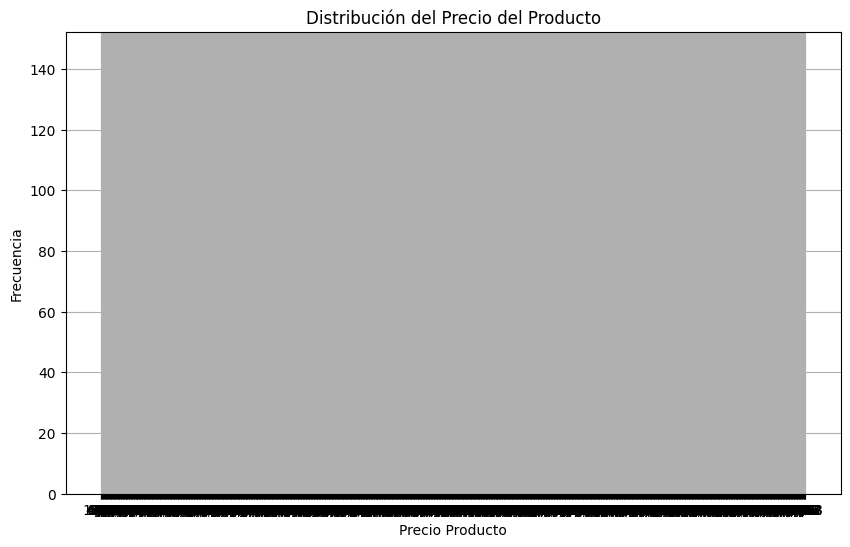

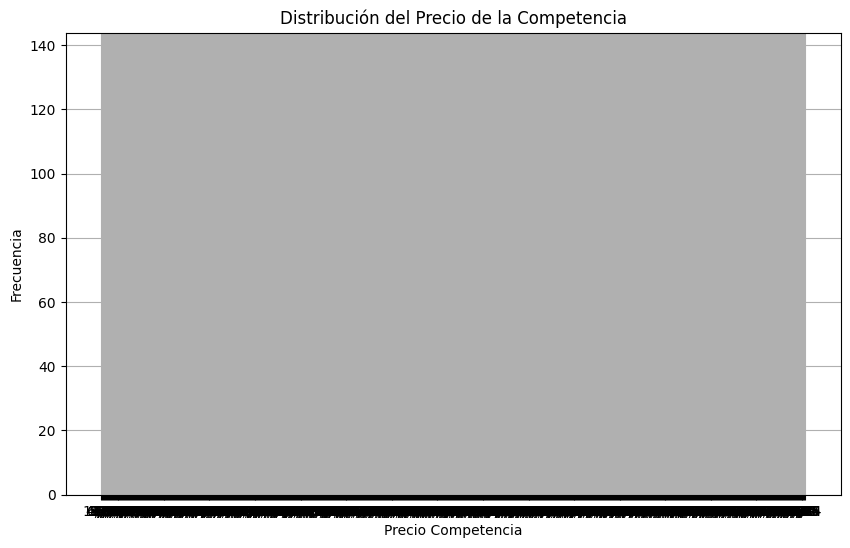

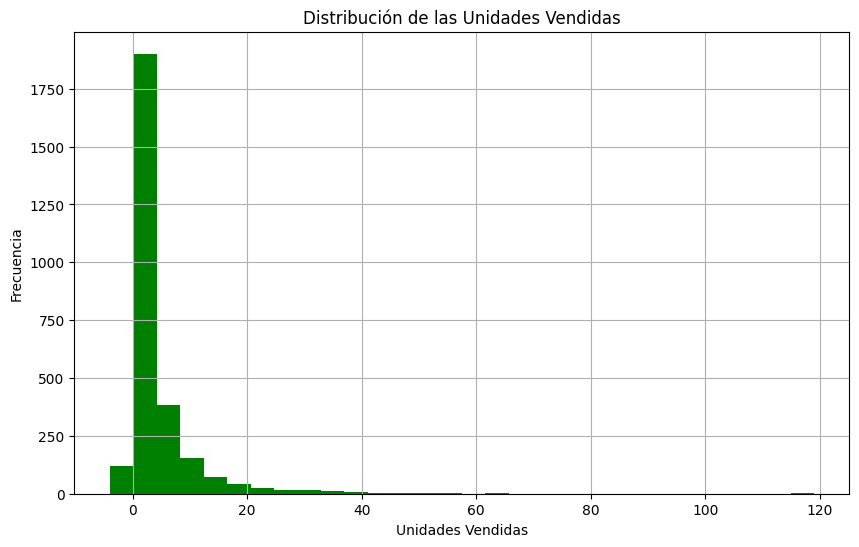

In [ ]:
# Distribución del precio del producto
plt.figure(figsize=(10,6))
data['precio_producto'].hist(bins=30)
plt.title('Distribución del Precio del Producto')
plt.xlabel('Precio Producto')
plt.ylabel('Frecuencia')
plt.show()

# Distribución del precio de la competencia
plt.figure(figsize=(10,6))
data['precio_competencia'].hist(bins=30, color='orange')
plt.title('Distribución del Precio de la Competencia')
plt.xlabel('Precio Competencia')
plt.ylabel('Frecuencia')
plt.show()

# Distribución de las unidades vendidas
plt.figure(figsize=(10,6))
data['unidades_vendidas'].hist(bins=30, color='green')
plt.title('Distribución de las Unidades Vendidas')
plt.xlabel('Unidades Vendidas')
plt.ylabel('Frecuencia')
plt.show()


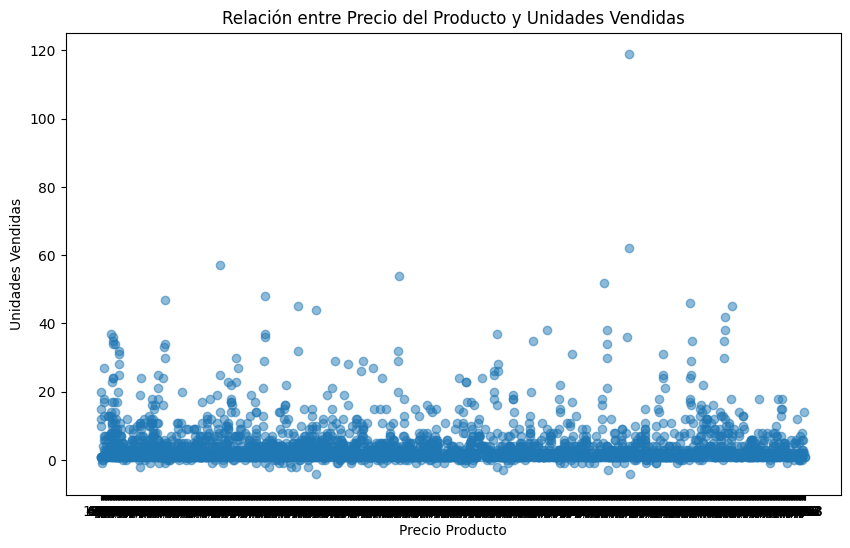

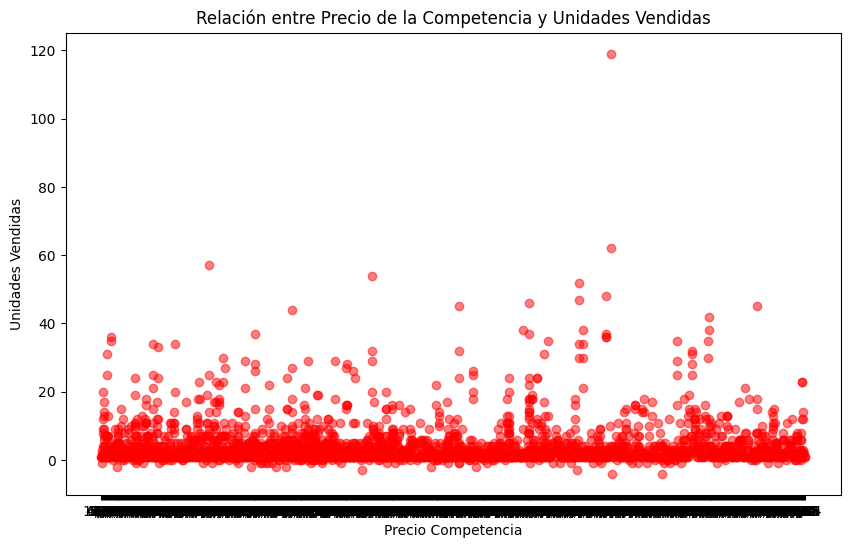

In [ ]:
# Relación entre el precio y las unidades vendidas
plt.figure(figsize=(10,6))
plt.scatter(data['precio_producto'], data['unidades_vendidas'], alpha=0.5)
plt.title('Relación entre Precio del Producto y Unidades Vendidas')
plt.xlabel('Precio Producto')
plt.ylabel('Unidades Vendidas')
plt.show()

# Relación entre el precio de la competencia y las unidades vendidas
plt.figure(figsize=(10,6))
plt.scatter(data['precio_competencia'], data['unidades_vendidas'], alpha=0.5, color='red')
plt.title('Relación entre Precio de la Competencia y Unidades Vendidas')
plt.xlabel('Precio Competencia')
plt.ylabel('Unidades Vendidas')
plt.show()


Matriz de correlación: Muestra la relación entre las variables clave.

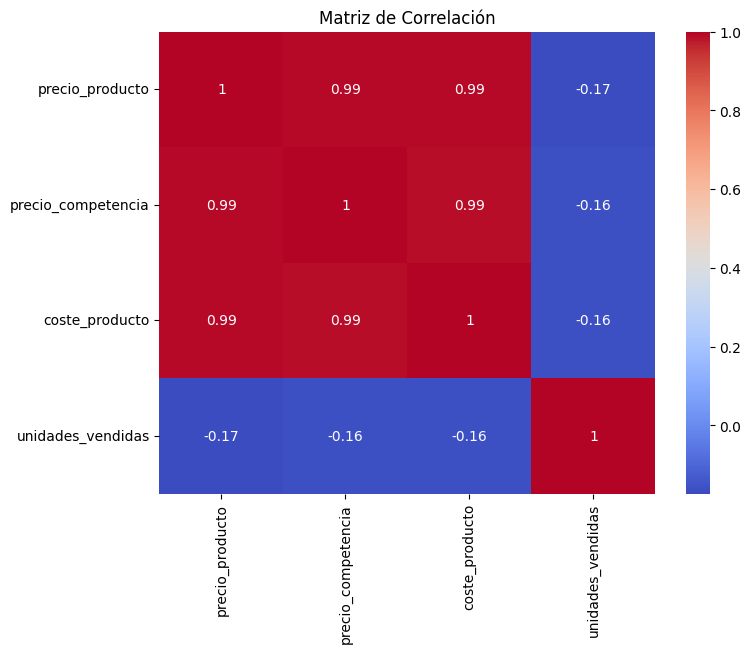

In [ ]:





# Matriz de correlación
corr_matrix = data[['precio_producto', 'precio_competencia', 'coste_producto', 'unidades_vendidas']].corr()

# Mapa de calor para visualizar la matriz de correlación
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

#Paso 4: Preparar los Datos para el modelo entrenarlo y comparar resultados

In [ ]:
# Variables predictoras (X) y objetivo (y)
X = data[['precio_producto', 'precio_competencia', 'coste_producto']]
y = data['unidades_vendidas']

# Dividimos los datos en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Entrenar múltiples modelos y comparar resultados

In [ ]:
# Importar los modelos adicionales
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Crear un diccionario para almacenar los modelos
modelos = {
    'Regresión Lineal': LinearRegression(),
    'Árbol de Decisión': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.1)
}

# Función para entrenar y evaluar modelos
resultados_rmse = {}

for nombre, modelo in modelos.items():
    # Entrenar el modelo
    modelo.fit(X_train, y_train)

    # Realizar predicciones en el conjunto de prueba
    y_pred = modelo.predict(X_test)

    # Calcular el RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Guardar el RMSE del modelo
    resultados_rmse[nombre] = rmse

    # Mostrar el RMSE del modelo
    print(f"RMSE del modelo {nombre}: {rmse:.4f}")

# Identificar el modelo con el menor RMSE
mejor_modelo_nombre = min(resultados_rmse, key=resultados_rmse.get)
mejor_rmse = resultados_rmse[mejor_modelo_nombre]

print(f"\nEl mejor modelo es {mejor_modelo_nombre} con un RMSE de {mejor_rmse:.4f}")


RMSE del modelo Regresión Lineal: 5.2365
RMSE del modelo Árbol de Decisión: 6.1983
RMSE del modelo Random Forest: 4.7335
RMSE del modelo XGBoost: 4.2489

El mejor modelo es XGBoost con un RMSE de 4.2489


#Paso 5: Entrenar el modelo de XGBoost

In [ ]:
# Entrenamos el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

# Realizamos predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluamos el rendimiento del modelo usando el RMSE (Raíz del Error Cuadrático Medio)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Mostramos el RMSE
print(f"RMSE del modelo: {rmse}")


RMSE del modelo: 5.2364998271762975


In [ ]:
# Crear un modelo XGBoost para regresión
xgb_model = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.1)

# Entrenar el modelo
xgb_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_xgb = xgb_model.predict(X_test)

# Evaluar el rendimiento del modelo XGBoost con RMSE
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print(f"RMSE del modelo XGBoost: {rmse_xgb}")


RMSE del modelo XGBoost: 4.248851056275171


#Paso 6: Optimización de precios

In [ ]:
# Función para optimizar el precio de cada producto agrupado usando XGBoost
def optimizar_precio_xgb(row):
    precio_min = row['coste_producto'] / 0.87
    precio_max = row['precio_producto'] * 1.2  # Limitar el precio máximo a un 20% más

    mejor_precio = row['precio_producto']
    mejor_ventas = row['unidades_vendidas']

    for nuevo_precio in np.arange(precio_min, precio_max, 0.01):
        pred_ventas = xgb_model.predict([[nuevo_precio, row['precio_competencia'], row['coste_producto']]])[0]
        if pred_ventas > mejor_ventas:
            mejor_precio = nuevo_precio
            mejor_ventas = pred_ventas

    return round(mejor_precio, 2)

# Aplicar la optimización de precios a los datos agrupados
data_agrupada['precio_optimizado'] = data_agrupada.apply(optimizar_precio_xgb, axis=1)


#Paso 7: Predicción de ventas con precios optimizados

In [ ]:
# Predicción de ventas con los precios actuales
data_agrupada['prediccion_ventas_actuales'] = xgb_model.predict(data_agrupada[['precio_producto', 'precio_competencia', 'coste_producto']])

# Predicción de ventas con los precios optimizados
def predecir_ventas_optimizadas_xgb(row):
    return xgb_model.predict([[row['precio_optimizado'], row['precio_competencia'], row['coste_producto']]])[0]

data_agrupada['prediccion_ventas_optimizadas'] = data_agrupada.apply(predecir_ventas_optimizadas_xgb, axis=1)


#Paso 8: Calcular márgenes y guardar resultados

In [ ]:
# Redondear las columnas relevantes a dos decimales, incluyendo el coste
data_agrupada['precio_producto'] = data_agrupada['precio_producto'].round(2)
data_agrupada['precio_optimizado'] = data_agrupada['precio_optimizado'].round(2)
data_agrupada['prediccion_ventas_actuales'] = data_agrupada['prediccion_ventas_actuales'].round(2)
data_agrupada['prediccion_ventas_optimizadas'] = data_agrupada['prediccion_ventas_optimizadas'].round(2)
data_agrupada['coste_producto'] = data_agrupada['coste_producto'].round(2)

# Calcular el margen con los precios actuales y optimizados
data_agrupada['margen_actual'] = ((data_agrupada['precio_producto'] - data_agrupada['coste_producto']) / data_agrupada['precio_producto']).round(2)
data_agrupada['margen_optimizado'] = ((data_agrupada['precio_optimizado'] - data_agrupada['coste_producto']) / data_agrupada['precio_optimizado']).round(2)

# Guardar los resultados finales en un archivo CSV
data_agrupada[['codigo_producto', 'coste_producto', 'precio_producto', 'precio_optimizado', 'margen_actual', 'margen_optimizado', 'prediccion_ventas_actuales', 'prediccion_ventas_optimizadas']].to_csv('resultado.csv', index=False)

# Descargar el archivo en Google Colab
files.download('resultado.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Paso 9: Evaluación de la optimización

In [ ]:
# Calcular el incremento porcentual en el margen después de la optimización
data_agrupada['incremento_margen'] = ((data_agrupada['margen_optimizado'] - data_agrupada['margen_actual']) / data_agrupada['margen_actual'] * 100).round(2)

# Calcular el incremento porcentual en las ventas después de la optimización
data_agrupada['incremento_ventas'] = ((data_agrupada['prediccion_ventas_optimizadas'] - data_agrupada['prediccion_ventas_actuales']) / data_agrupada['prediccion_ventas_actuales'] * 100).round(2)

# Evaluación general: promedios de incremento de margen y ventas
evaluacion_incremento_margen = data_agrupada['incremento_margen'].mean()
evaluacion_incremento_ventas = data_agrupada['incremento_ventas'].mean()

# Mostrar la evaluación general
print(f"Promedio de incremento en el margen: {evaluacion_incremento_margen:.2f}%")
print(f"Promedio de incremento en las ventas: {evaluacion_incremento_ventas:.2f}%")

# Guardar los resultados detallados de la evaluación en un archivo CSV
data_agrupada[['codigo_producto', 'coste_producto', 'precio_producto', 'precio_optimizado', 'margen_actual', 'margen_optimizado', 'prediccion_ventas_actuales', 'prediccion_ventas_optimizadas', 'incremento_margen', 'incremento_ventas']].to_csv('evaluacion_optimizacion.csv', index=False)

# Descargar el archivo en Google Colab
files.download('evaluacion_optimizacion.csv')


Promedio de incremento en el margen: -7.62%
Promedio de incremento en las ventas: 61.88%


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>